# Applying the Hypergeometric Distribution to Social Network Graphs
#### Michael Lanier NGA DCD
#### 6/17/2019

## To Do List:

The recent rise of supervised machine learning algorithms has led to wide spread use across industry and academia. Proponents of these techniques often market them as magical in their ability to gain insight from data. Unfortunately social networks data violates many of the core assumptions that most machine learning techniques relay on. Traditional regression techniques fail for the same reason.

The main issue with traditional regression and machine learning is that samples are not independent and identically distributed. A sampling technique that finds a paricular user in a network may be more likely to sample others in the network. Beyond that, members of a network who know each other are likely to know first and second removed members. Finally, in the cases of small networks sampling is from a finite population. This paper will primarly focus determining anamolous members of a social network.

Walford noted in *Geographic Data Analysis* that a network could be viewed as a collection of vertcies randomly connected by edges. Sampling edges would follow a hypergeometric distribution. Under this framework a vertex would correspond to a member and a edge would correspond to a connection. The probability that a member randomly has a specificed number of connections will be considered first. 

The probability that a particular vertex $a$ will randomly have the number of vertices  within graph $G$ will be noted as $P(a_G)$. The following formula will be useful for the following work. We will introduce the hypergeometric distribution for social networks assuming independent edge selection. 

**Definition 1** *Hypergeometric Distribution*

Consider a $n$ vertex $j$ edge graph such that $k$ edges are connected to $a_i$. Assuming that the edges were randomly sampled independently with equal probability. 

$P(a_i)=\frac{\binom{n-1}{k}\binom{N-n+1}{j-k}}{\binom{N}{j}} \\s.t \\  N=\frac{n(n-1)}{2}$

The distribution of edges follows a hypergeometric distribution since we are sampling from possible edges without replacement. $N$ is the total number of possible paths. It is trival to show for a n vertices the total possible edges are $\frac{n(n+1)}{2}$. The denominator is the total number of possible $n$ vertex $j$ edge graphs. The numerator is the total number of graphs in a given orientation. The first term is the number of ways $k$ edges could be selected for a vertex. For a given vertex there are $n-1$ possible edges from which to select $k$ edges. The second term is the number of ways to select the from the remaining $N-(n-1)$ the remaining $j-k$ edges. 

**Example 1**
Consider the below graph $G1$. Find $P(a_3)$.
![title](graph1.PNG)

$P(a_3)=\frac{\binom{4}{2}\binom{6}{4}}{\binom{10}{6}} \approx .42$

$a_3$ does not appear to be very anomalous.

**Example 2**
Consider the below graph $G2$. Find $P(a_4)$.
![title](graph2.PNG)

$P(a_4)=\frac{\binom{5}{5}\binom{6}{1}}{\binom{21}{6}} \approx .0001$

$a_4$ appears anomalous given this network.


As noted before, the technique above assumes that edges are independent from each other. Let's remove that restriction and assume that the network is weighted. An individual in a social network that knows many people will be more likely to aquire new connections. For this we will use the Wallenius' non central hypergeometric distribution. Here $w$ is the odds of an edge being connected to the vertex in question.

**Definition 2** *Wallenius' non central hypergeometric distribution*

$P(a_i)=\binom{n-1}{k}\binom{N-n+1}{j-k} \int_{0}^{1} (1-t^{w/D})^{k}(1-t^{1/D})^{j-k}  dt  \\ s.t\\ D=w(j-k)+(N-n+1-(j-k))$ 

**Example 3**

Consider the the graph from example one. Find $P(a_3)$, provided the odds of an edge being connected to $a_3$ are $\frac{1}{10}$.

$P(a_3)=\binom{4}{2}\binom{6}{4} \int_{0}^{1} (1-t^{.01/D})^{2}(1-t^{1/D})^{4}  dt  \\ s.t\\ D=.01(4)+(6-(4))=2.04 \\ P(a_3) \approx .001$ 

Here we see with prior knowlege that $a_3$ is unlikely, the liklihood that $a_3$ is connected within the graph drops from .42 to .001. Of course, the downside is that we must specify a prior $w$ before using this technique. We may not wish to specify a prior on $w$. Since $w$ is the weight parameter, $w$ may be of interest because it shows the bias of a particular vertex is in the graph. In a randomly generated network verticies with high weight will naturally develop more edges. In a social network context such a person could be said to have high influence. The sampling method may also be biased towards this node. We will use numerical techniques to find the estimator $\hat{w}$. We specially use Nesterov Adam, a stochastic adaptive learning optimization algorithm.

**Definition 3**

$\hat{w}= \underset{w\in R_{+}}{\operatorname{argmax}}\binom{n-1}{k}\binom{N-n+1}{j-k} \int_{0}^{1} (1-t^{w/D})^{k}(1-t^{1/D})^{j-k}  dt  \\ s.t\\ D=w(j-k)+(N-n+1-(j-k))$ 

**Example 4**
We will estimate $\hat{w}$ for $a3$ from $G1$. 

In [1]:
import tensorflow as tf
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

#Tensorflow has no binomial coefficient so we will use n!= gamma(n+1) as a workaround
def factorial(n):
    sess=tf.Session()
    n=n*1.0000
    F=tf.round(tf.exp(tf.lgamma(n+1)))
    F=sess.run(F)
    return(F)

def binomial_coeff(a,b,factorial=factorial):
    c=factorial(a)/(factorial(a-b)*factorial(b))
    return(c)

D:\Anaconda\lib\site-packages\requests\__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


In [2]:

w=tf.Variable(tf.random_uniform([], 0,1))
x=tf.constant([0,1], dtype=tf.float32)
N=10
n=5
j=6
k=2
D=w*(j-k)+(N-n+1-(j-k))

def f(y,t):
    return((1-t**(w/D))**k*(1-t**(1/D))**(j-k))

sess=tf.Session()

optimizer=tf.contrib.opt.NadamOptimizer(learning_rate=.01, beta1=.9, beta2=.999, epsilon=1e-08)
L=binomial_coeff(n-1,k)*binomial_coeff(N-n+1,j-k)* tf.contrib.integrate.odeint(f,0.000,x, method="dopri5")

train=optimizer.minimize(-1*L[1])
init= tf.global_variables_initializer()

Results=np.zeros([1,2])
Last_L=10000

sess=tf.Session()
sess.run(init)

print("Step|w|L")
for step in range(101):
    sess.run(train)
    Results=np.concatenate((Results,np.array([[sess.run(w),sess.run(L[1])]])),axis=0)
    print(step,sess.run(w),sess.run(L[1]))
    #implement early stopping
    if step!=100 and step>3 and np.abs(sess.run(L[1])-Last_L)<.001:
        break
    Last_L= sess.run(L[1]) 
    
Results=np.delete(Results,0,axis=0)    



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Step|w|L
0 0.033979222 0.013481921
1 0.04925965 0.025040977
2 0.06272485 0.036510624
3 0.07522758 0.047684543
4 0.08714531 0.058470238
5 0.098665714 0.06880199
6 0.109889425 0.07862941
7 0.1208722 0.08791631
8 0.13164449 0.09663904
9 0.14222157 0.104785524
10 0.15260914 0.11235355
11 0.16280676 0.11934904
12 0.1728101 0.12578537
13 0.18261229 0.13168108
14 0.1922051 0.13705924
15 0.20157956 0.14194621
16 0.21072659 0.14637022
17 0.21963738 0.15036133
18 0.22830369 0.15394968
19 0.23671812 0.15716556
20 0.2448742 0.16003942
21 0.25276655 0.16259967
22 0.2603909 0.16487445
23 0.26774415 0.16688982
24 0.27482432 0.16867076
25 0.28163058 0.17024085
26 0.28816313 0.17162095
27 0.29442322 0.17283158
28 0.30041304 0.17389049
29 0.30613562 0.17481469


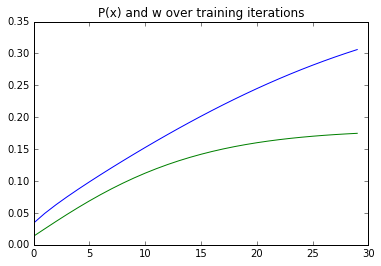

In [3]:
%matplotlib inline
from matplotlib import pyplot
plt.plot(Results)
plt.title("P(x) and w over training iterations")
plt.show()

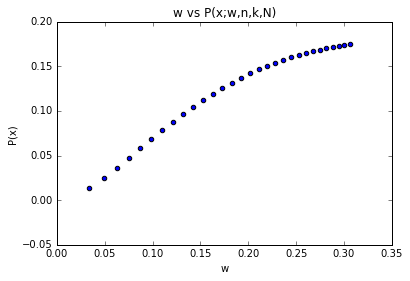

In [4]:
plt.scatter(x=Results[:,0],y=Results[:,1])
plt.title("w vs P(x;w,n,k,N)")
plt.xlabel("w")
plt.ylabel("P(x)")
plt.show()

$w$ can be used as an alternative measure of degree centrality. The draw here is that we can establish error bounds on this statistic to evaluate the strength of evidence of its centrality. This proves problematic because the distribution of $\hat{w}$ is unknown. We will utilized likelihood ratios to estimate the evidence of centrality. The goal will be to form an interval summary from the likelihood. Such an interval includes all $\hat{w}$ having data support above a specified cut-off $c$.

In [5]:
LR_space=np.zeros([1,2])
w_space=np.linspace(0,5,num=101)
x=tf.constant([0,1], dtype=tf.float32)
D=w*(j-k)+(N-n+1-(j-k))
N=10
n=5
j=6
k=2

def f(y,t):
    return((1-t**(w/D))**k*(1-t**(1/D))**(j-k))

sess=tf.Session()
init= tf.global_variables_initializer()
sess.run(init)
for i in range(40):
    w=tf.constant(w_space[i], dtype=tf.float32)
    D=w*(j-k)+(N-n+1-(j-k))
    LR=(binomial_coeff(n-1,k)*binomial_coeff(N-n+1,j-k)* tf.contrib.integrate.odeint(f,0.000,x, method="dopri5"))/max(Results[:,1])
    LR_space=np.concatenate((LR_space,np.array([[w_space[i],sess.run(LR[1])]])),axis=0)
    print(w_space[i],sess.run(LR[1]))

LR_space=np.delete(LR_space,0,axis=0) 

0.0 0.0
0.05 0.1467124
0.1 0.40033826
0.15000000000000002 0.6320638
0.2 0.80741525
0.25 0.9251316
0.30000000000000004 0.9943135
0.35000000000000003 1.0259321
0.4 1.0298958
0.45 1.0142647
0.5 0.9852704
0.55 0.9475863
0.6000000000000001 0.9046452
0.65 0.85892785
0.7000000000000001 0.8121966
0.75 0.7656812
0.8 0.7202218
0.8500000000000001 0.67636466
0.9 0.63446003
0.9500000000000001 0.59470046
1.0 0.5571771
1.05 0.5219056
1.1 0.48885024
1.1500000000000001 0.4579425
1.2000000000000002 0.4290917
1.25 0.40219423
1.3 0.37713745
1.35 0.3538096
1.4000000000000001 0.33209875
1.4500000000000002 0.31189495
1.5 0.29309344
1.55 0.2755942
1.6 0.2593033
1.6500000000000001 0.24413171
1.7000000000000002 0.22999755
1.75 0.2168234
1.8 0.20453799
1.85 0.1930755
1.9000000000000001 0.18237436
1.9500000000000002 0.17237827


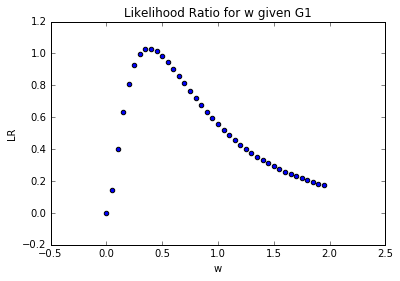

In [6]:
plt.scatter(x=LR_space[:,0],y=LR_space[:,1])
plt.title("Likelihood Ratio for w given G1")
plt.xlabel("w")
plt.ylabel("LR")
plt.show()

A frequentist confidence interval matches a Wilks' liklihood test when $LR=e^{\chi_{\alpha,t}^{2}/2}$. A 95% confidence interval would give a likelihood ratio cutoff of appoximatly .15. From our above example we have $w \in [.63,1.95]$.

### Considerations for Large $N$,$n$ values

For large $N$ and $n$ we have a computational problem. Modern computers cannot cacluate facrotial values of 50 or more. We will consider how to apply these techniques in the presence of large networks.

For the noncentral hyper geometric distirbution we don't need to be concerned with large $N$ and $n$. The argmax $\hat{w}$ doesn't depend on $N$ or $n$ factorial terms. We see:
$\binom{n-1}{k}\binom{N-n+1}{j-k} \int_{0}^{1} (1-t^{w/D})^{k}(1-t^{1/D})^{j-k}  dt \propto \int_{0}^{1} (1-t^{w/D})^{k}(1-t^{1/D})^{j-k}  dt$

So

$\hat{w}= \underset{w\in R_{+}}{\operatorname{argmax}}\binom{n-1}{k}\binom{N-n+1}{j-k} \int_{0}^{1} (1-t^{w/D})^{k}(1-t^{1/D})^{j-k}  dt = \underset{w\in R_{+}}{\operatorname{argmax}} \int_{0}^{1} (1-t^{w/D})^{k}(1-t^{1/D})^{j-k}  dt  \\ s.t\\ D=w(j-k)+(N-n+1-(j-k))$ 

**Example 5**
We will estimate $\hat{w}$ for a network with 1000 nodes, 121 which are connected to a given node $a$, with 6000 connections.

In [7]:
w=tf.Variable(tf.random_uniform([], 0,1))
x=tf.constant([0,1], dtype=tf.float32)
N=1000/2*1001
n=1000
j=6000
k=121
D=w*(j-k)+(N-n+1-(j-k))

def f1():
    return tf.constant(.0000000000001)

def f2():
    return w/D

def f3():
    return w/D

def f(y,t):
    tf.cond(tf.less(w/D,.0000000000001),f1,f2)
    tf.cond(tf.less(1/D,.0000000000001),f1,f3)    
    return((1-t**(w/D))**k*(1-t**(1/D))**(j-k))

sess=tf.Session()

optimizer=tf.contrib.opt.NadamOptimizer(learning_rate=.01, beta1=.9, beta2=.999, epsilon=1e-08)
L= tf.contrib.integrate.odeint(f,0.000,x, method="dopri5")

train=optimizer.minimize(-1*L[1])
init= tf.global_variables_initializer()

Results=np.zeros([1,2])
Last_L=10000

sess=tf.Session()
sess.run(init)

print("Step|w|L")
for step in range(101):
    sess.run(train)
    Results=np.concatenate((Results,np.array([[sess.run(w),sess.run(L[1])]])),axis=0)
    print(step,sess.run(w),sess.run(L[1]))
    #implement early stopping
    #if step!=100 and step>3 and np.abs(sess.run(L[1])-Last_L)<.001:
    #    break
    Last_L= sess.run(L[1]) 
    
Results=np.delete(Results,0,axis=0)    


Step|w|L


InvalidArgumentError: assertion failed: [underflow in dt] [0]
	 [[node odeint_41/interpolate_loop/interpolate/integrate_loop/assertions/Assert/AssertGuard/Assert (defined at <ipython-input-7-5c7aff27c6ef>:26) ]]

Caused by op 'odeint_41/interpolate_loop/interpolate/integrate_loop/assertions/Assert/AssertGuard/Assert', defined at:
  File "D:\Anaconda\lib\runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "D:\Anaconda\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\Anaconda\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "D:\Anaconda\lib\site-packages\traitlets\config\application.py", line 596, in launch_instance
    app.start()
  File "D:\Anaconda\lib\site-packages\ipykernel\kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "D:\Anaconda\lib\site-packages\zmq\eventloop\ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "D:\Anaconda\lib\site-packages\tornado\ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "D:\Anaconda\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\Anaconda\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "D:\Anaconda\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "D:\Anaconda\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "D:\Anaconda\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\Anaconda\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "D:\Anaconda\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "D:\Anaconda\lib\site-packages\ipykernel\kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "D:\Anaconda\lib\site-packages\ipykernel\ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-5c7aff27c6ef>", line 26, in <module>
    L= tf.contrib.integrate.odeint(f,0.000,x, method="dopri5")
  File "C:\Users\cv11515\AppData\Roaming\Python\Python35\site-packages\tensorflow\contrib\integrate\python\ops\odes.py", line 540, in odeint
    **options)
  File "C:\Users\cv11515\AppData\Roaming\Python\Python35\site-packages\tensorflow\contrib\integrate\python\ops\odes.py", line 405, in _dopri5
    name='interpolate_loop')
  File "C:\Users\cv11515\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\ops\control_flow_ops.py", line 3556, in while_loop
    return_same_structure)
  File "C:\Users\cv11515\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\ops\control_flow_ops.py", line 3087, in BuildLoop
    pred, body, original_loop_vars, loop_vars, shape_invariants)
  File "C:\Users\cv11515\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\ops\control_flow_ops.py", line 3022, in _BuildLoop
    body_result = body(*packed_vars_for_body)
  File "C:\Users\cv11515\AppData\Roaming\Python\Python35\site-packages\tensorflow\contrib\integrate\python\ops\odes.py", line 383, in interpolate
    name='integrate_loop')
  File "C:\Users\cv11515\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\ops\control_flow_ops.py", line 3556, in while_loop
    return_same_structure)
  File "C:\Users\cv11515\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\ops\control_flow_ops.py", line 3087, in BuildLoop
    pred, body, original_loop_vars, loop_vars, shape_invariants)
  File "C:\Users\cv11515\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\ops\control_flow_ops.py", line 3022, in _BuildLoop
    body_result = body(*packed_vars_for_body)
  File "C:\Users\cv11515\AppData\Roaming\Python\Python35\site-packages\tensorflow\contrib\integrate\python\ops\odes.py", line 339, in adaptive_runge_kutta_step
    ['underflow in dt', dt])
  File "C:\Users\cv11515\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\util\tf_should_use.py", line 193, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs))
  File "C:\Users\cv11515\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\ops\control_flow_ops.py", line 168, in Assert
    guarded_assert = cond(condition, no_op, true_assert, name="AssertGuard")
  File "C:\Users\cv11515\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\cv11515\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\ops\control_flow_ops.py", line 2108, in cond
    orig_res_f, res_f = context_f.BuildCondBranch(false_fn)
  File "C:\Users\cv11515\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\ops\control_flow_ops.py", line 1941, in BuildCondBranch
    original_result = fn()
  File "C:\Users\cv11515\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\ops\control_flow_ops.py", line 166, in true_assert
    condition, data, summarize, name="Assert")
  File "C:\Users\cv11515\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\ops\gen_logging_ops.py", line 72, in _assert
    name=name)
  File "C:\Users\cv11515\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\cv11515\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\cv11515\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\framework\ops.py", line 3300, in create_op
    op_def=op_def)
  File "C:\Users\cv11515\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\framework\ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): assertion failed: [underflow in dt] [0]
	 [[node odeint_41/interpolate_loop/interpolate/integrate_loop/assertions/Assert/AssertGuard/Assert (defined at <ipython-input-7-5c7aff27c6ef>:26) ]]


For large $N$,$n$ in a hypergeometric sampling scheme such as example 1, we can use the normal distribution. To develop this result we will first observe that the hypergeometric distribution converges in distribution to the binomial distribution.  

The hypergeometric distribution models sampling without replacement, and the binomial distribution models sampling with replacement. When sampling from an extremly large set, it is unlikly to resample with replacement. Intuitively, this means for large $N$, $n$ sampling without replacement approximates sampling with replacement. We will prove this rigorously. First we will need an identity.  

**Lemma 1**
$\binom{n}{k} \approx \frac{n^{k}}{k!}$

**pf:** $\binom{n}{k}=\frac{n!}{n!(n-k)!}$ Using Sterling's approximation, 

$\binom{n}{k}=\frac{n!}{n!(n-k)!}\approx \frac{\sqrt{2\pi n}}{k!\sqrt{(2\pi)(n-k)(n-k/e)^{n-k}}}=(1-k/n)^{k-1/2}\frac{e^{-k}}{k!(1-k/n)^{n}}n^{k}$

$\displaystyle{\lim_{n \to \infty} (1-k/n)}^{k-1/2}=1$

$\displaystyle{\lim_{n \to \infty}} \frac{e^{-k}}{k!(1-k/n)^{n}}n^{k}=\frac{e^{-k}}{k!e^{-k}}n^{k}=\frac{n^{k}}{k!}$

**Theorem 1**

$P(a_i)=\frac{\binom{n-1}{k}\binom{N-n+1}{j-k}}{\binom{N}{j}} \xrightarrow{\text{d}} \binom{j}{k}(\frac{n-1}{N})^{k}(\frac{N-n+1}{N})^{j-k} \\s.t \\  N=\frac{n(n-1)}{2}$

$\frac{\binom{n-1}{k}\binom{N-n+1}{j-k}}{\binom{N}{j}}=\displaystyle{\lim_{n \to \infty}\frac{(n-1)^{k}}{k!}}\frac{(N-n+1)^{j-k}}{(j-k)!}\frac{j!}{N^{j}}=\binom{j}{k}\frac{(n-1)^{k}}{N^{k}}\frac{(N-n+1)^{j-k}}{N^{j-k}}=  \binom{j}{k}(\frac{n-1}{N})^{k}(\frac{N-n+1}{N})^{j-k}$

The right side is a binomial distirbution with $p=\frac{n-1}{N}$ and $q=\frac{N-n+1}{N}$.

$P(a_i)\approx b(k;j,\frac{n-1}{N})=\binom{j}{k}(\frac{n-1}{N})^{k}(\frac{N-n+1}{N})^{j-k}$, for large $N$,$n$.

Assuming $0<p<1$,$0<q<1$ the De Moivre-Laplace Theorem gives us a normal approximation absent any factorials.

$P(a_i)\approx \Phi(\frac{k-(j-k)(n-1)/N}{\sqrt{(j-k)(n-1)(N-n+1)N^{-2}}})-\Phi(\frac{(k-1)-(j-k)(n-1)/N}{\sqrt{(j-k)(n-1)(N-n+1)N^{-2}}})$

**Example 6**

Determine the probability of a node a randomly being generated in a network with 1000 nodes, 121 which are connected to a given node $a$, with 6000 connections where the connections are independently generated.

In [ ]:
from scipy.stats import norm
N=1000/2*1001
n=1000
j=6000
k=121


Num1=k-(j-k)*(n-1)/N
Den1=np.sqrt((j-k)*(n-1)*(N-n+1)*N**-2)
Num2=k-1-(j-k)*(n-1)/N
Den2=np.sqrt((j-k)*(n-1)*(N-n+1)*N**-2)
norm.cdf(Num1/Den1)-norm.cdf(Num2/Den2)

This is nearly impossible assuming totally random selection. We conclude that this node is highly anomolous. 

**Example 7**

Let's see how close this approximation is to the exact values with low $N$,$n$ from our first example.

In [ ]:

N=10
n=5
j=6
k=2
Num1=k-(j-k)*(n-1)/N
Den1=np.sqrt((j-k)*(n-1)*(N-n+1)*N**-2)
Num2=k-1-(j-k)*(n-1)/N
Den2=np.sqrt((j-k)*(n-1)*(N-n+1)*N**-2)
norm.cdf(Num1/Den1)-norm.cdf(Num2/Den2)